In [5]:
from kan import *
import torch
import matplotlib.pyplot as plt
from torch import autograd
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(device)

cpu
checkpoint directory created: ./model
saving model version 0.0
Dataset shapes: torch.Size([1000, 6]) torch.Size([1000, 1])
saving model version 0.1
saving model version 0.2
saving model version 0.3
saving model version 0.4


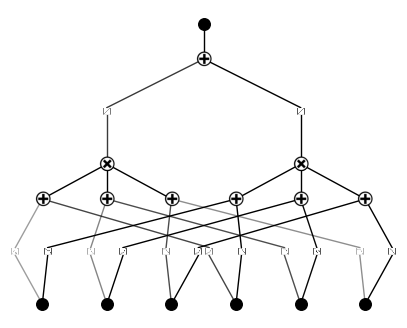

In [119]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

NUM_ELECTRONS = 2
INPUT_DIM = NUM_ELECTRONS * 3
OUTPUT_DIM = NUM_ELECTRONS


# Create MultKAN model with specified widths
# Create the initial MultKAN model
model = MultKAN(width=[INPUT_DIM, [0, OUTPUT_DIM], 1], grid=5, k=2, seed=42, mult_arity=3)

# Create dataset
f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
dataset = create_dataset(f, n_var=INPUT_DIM)
print("Dataset shapes:", dataset['train_input'].shape, dataset['train_label'].shape)

def chain_str(in_out_dim: int, num_electrons: int) -> str:
    connection_idxs = list(range(in_out_dim))

    # Get first, second, and third third of input indices
    radial_indices = connection_idxs[0::3]
    theta_indices = connection_idxs[1::3]
    phi_indices = connection_idxs[2::3]

    # Get output indices with remainders 0, 1, and 2 when divided by 3
    radial_electrons = [i for i in range(in_out_dim) if i % 3 == 0]
    theta_electrons = [i for i in range(in_out_dim) if i % 3 == 1]
    phi_electrons = [i for i in range(in_out_dim) if i % 3 == 2]

    # Create three chains
    first_chain = f'{radial_electrons}->{radial_indices}'
    second_chain = f'{theta_electrons}->{theta_indices}'
    third_chain = f'{phi_electrons}->{phi_indices}'

    return [first_chain, second_chain, third_chain]

chains = chain_str(INPUT_DIM, NUM_ELECTRONS)

# Set up all connections
for chain in chains:
    model.module(0, chain)
       
# # Create chain for final layer where all intermediate nodes connect to output
final_indices = list(range(OUTPUT_DIM))
final_chain = f'{final_indices}->[0]'
model.module(1, final_chain)

model(dataset['train_input'])
model.plot(beta=10)

cpu
checkpoint directory created: ./model
saving model version 0.0
Dataset shapes: torch.Size([1000, 6]) torch.Size([1000, 1])
saving model version 0.1
saving model version 0.2
saving model version 0.3
saving model version 0.4


Exception: model hasn't seen any data yet.

Epoch 0, Loss: 0.462812
Epoch 100, Loss: 0.000139
Epoch 200, Loss: 0.000117
Epoch 300, Loss: 0.000107
Epoch 400, Loss: 0.000097
Epoch 500, Loss: 0.000086
Epoch 600, Loss: 0.000075
Epoch 700, Loss: 0.000065
Epoch 800, Loss: 0.000055
Epoch 900, Loss: 0.000046
Epoch 0, Loss: 0.361352
Epoch 100, Loss: 0.006150
Epoch 200, Loss: 0.002688
Epoch 300, Loss: 0.001243
Epoch 400, Loss: 0.000518
Epoch 500, Loss: 0.000179
Epoch 600, Loss: 0.000052
Epoch 700, Loss: 0.000014
Epoch 800, Loss: 0.000005
Epoch 900, Loss: 0.000003

Results for m=0:
MSE: 0.000041
R² Score: 0.999919
Chebyshev coefficients:
T_0(x): 0.092993
T_1(x): -0.407952
T_2(x): 0.108907
T_3(x): 0.289282
T_4(x): 0.015690
T_5(x): 0.071309

Results for m=1:
MSE: 0.000003
R² Score: 0.999969
Chebyshev coefficients:
T_0(x): 0.178701
T_1(x): 0.450394
T_2(x): -0.581858
T_3(x): 0.061516
T_4(x): -0.061754
T_5(x): 0.008136


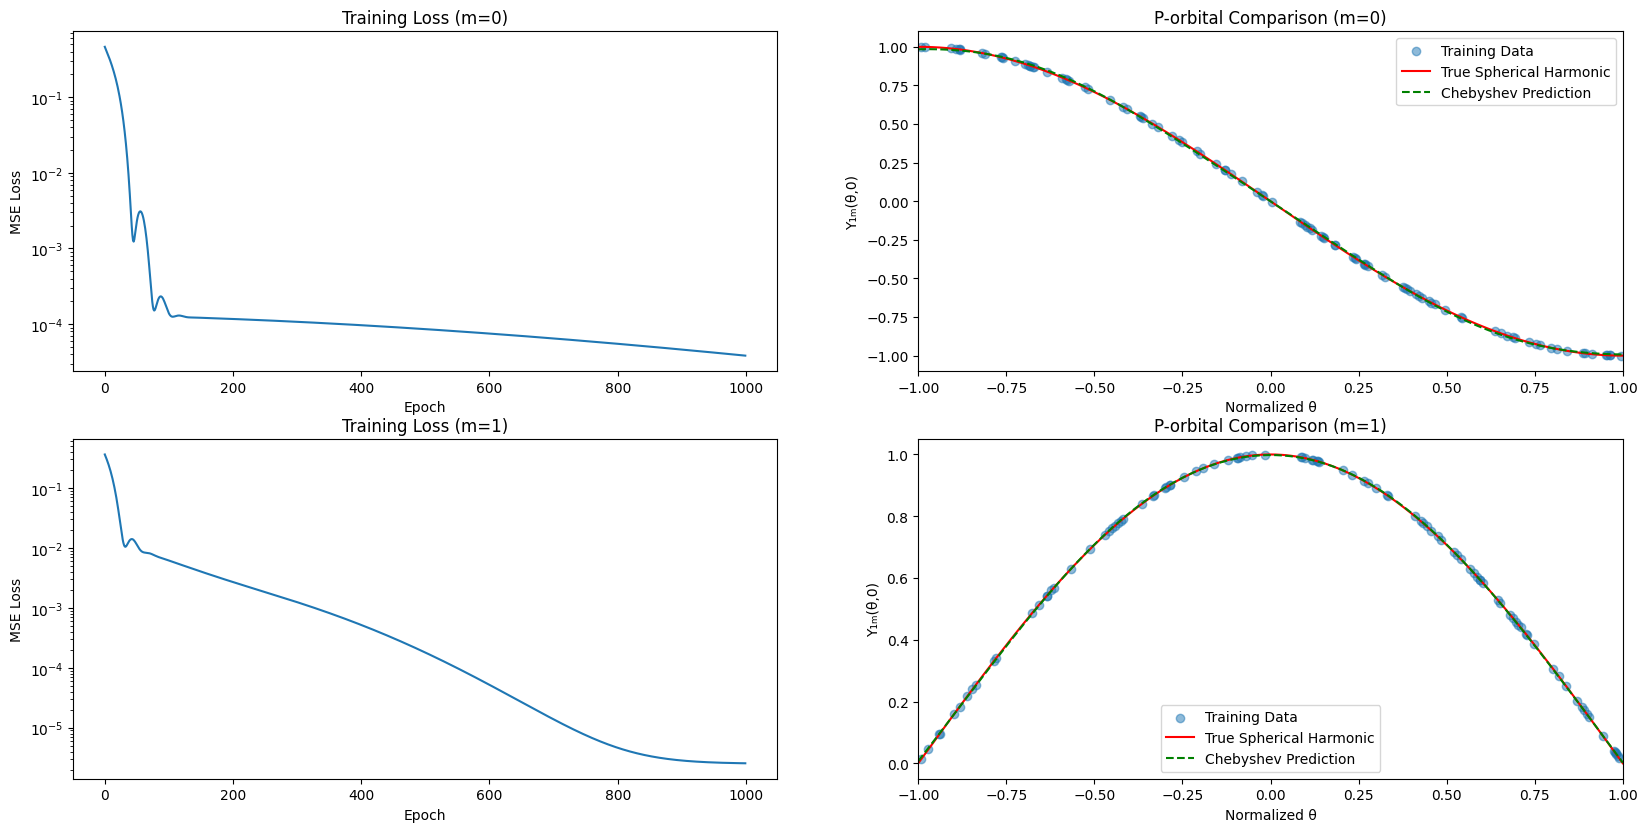

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import sph_harm
from kan.KANLayer_cheb import 

# Define spherical harmonics for p-orbitals (l=1)
def p_orbital_spherical_harmonics(theta, m=0):
    """
    Calculate p-orbital spherical harmonics Y₁ₘ(θ,φ=0)
    l=1 for p-orbitals, m can be -1, 0, 1
    We fix φ=0 for 2D visualization
    """
    if m == 0:  # pz: Y₁₀ ∝ cos(θ)
        return np.cos(theta)
    elif m == 1:  # px: Y₁₁ ∝ sin(θ)
        return np.sin(theta)
    elif m == -1:  # py: Y₁₋₁ ∝ sin(θ)
        return np.sin(theta)
    else:
        raise ValueError("m must be -1, 0, or 1 for p-orbitals")

def normalize_domain(x, original_range=[0, np.pi], target_range=[-1, 1]):
    """Map values from original range to target range"""
    x_std = (x - original_range[0]) / (original_range[1] - original_range[0])
    return x_std * (target_range[1] - target_range[0]) + target_range[0]

def denormalize_domain(x, original_range=[0, np.pi], target_range=[-1, 1]):
    """Map values back from target range to original range"""
    x_std = (x - target_range[0]) / (target_range[1] - target_range[0])
    return x_std * (original_range[1] - original_range[0]) + original_range[0]

# Create datasets for different p-orbitals
def create_dataset(m=0, n_samples=100, device='cpu'):
    # Generate uniform samples in [-1, 1]
    x = 2 * torch.rand(n_samples, 1).to(device) - 1
    x, _ = torch.sort(x, dim=0)
    
    # Convert to original domain and compute spherical harmonic
    theta = denormalize_domain(x).numpy()
    y = torch.tensor(p_orbital_spherical_harmonics(theta, m)).float().view(-1, 1)
    
    return x, y

# Create and train model for each m value
def train_model(x_train, y_train, degree=5, n_epochs=1000):
    model = ChebKANLayer(
        in_dim=1,
        out_dim=1,
        degree=degree,
        noise_scale=0.1,
        device=device
    )
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    losses = []
    
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        y_pred, _, _, _ = model(x_train)
        loss = torch.nn.functional.mse_loss(y_pred, y_train)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item():.6f}')
            
    return model, losses

# Training and visualization
device = 'cpu'
m_values = [0, 1]  # pz and px/py orbitals
models = {}
losses_dict = {}

# Create figure for all plots
plt.figure(figsize=(20, 15))

# Train models for each m value
for idx, m in enumerate(m_values):
    x_train, y_train = create_dataset(m=m)
    model, losses = train_model(x_train, y_train)
    models[m] = model
    losses_dict[m] = losses

    # Create test points
    x_test = torch.linspace(-1, 1, 200).view(-1, 1)
    theta_test = denormalize_domain(x_test).numpy()
    y_true = p_orbital_spherical_harmonics(theta_test, m)
    y_pred, _, _, _ = model(x_test)

    # Plot training curve
    plt.subplot(3, 2, idx*2 + 1)
    plt.plot(losses)
    plt.yscale('log')
    plt.title(f'Training Loss (m={m})')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')

    # Plot function comparison
    plt.subplot(3, 2, idx*2 + 2)
    plt.scatter(x_train.numpy(), y_train.numpy(), label='Training Data', alpha=0.5)
    plt.plot(x_test.numpy(), y_true, 'r-', label='True Spherical Harmonic')
    plt.plot(x_test.numpy(), y_pred.detach().numpy(), 'g--', label='Chebyshev Prediction')
    plt.legend()
    plt.title(f'P-orbital Comparison (m={m})')
    plt.xlabel('Normalized θ')
    plt.ylabel('Y₁ₘ(θ,0)')
    plt.xlim([-1, 1])



# Print quantitative comparison
for m in m_values:
    x_test = torch.linspace(-1, 1, 200).view(-1, 1)
    theta_test = denormalize_domain(x_test).numpy()
    y_true = torch.tensor(p_orbital_spherical_harmonics(theta_test, m)).float()
    y_pred, _, _, _ = models[m](x_test)
    
    mse = torch.nn.functional.mse_loss(y_pred, y_true)
    
    # Calculate R² score
    y_mean = torch.mean(y_true)
    ss_tot = torch.sum((y_true - y_mean) ** 2)
    ss_res = torch.sum((y_true - y_pred) ** 2)
    r2 = 1 - ss_res / ss_tot
    
    print(f'\nResults for m={m}:')
    print(f'MSE: {mse:.6f}')
    print(f'R² Score: {r2:.6f}')

    # Print Chebyshev coefficients
    print(f'Chebyshev coefficients:')
    coeffs = models[m].coef.detach().numpy()[0, 0, :]
    for i, c in enumerate(coeffs):
        print(f'T_{i}(x): {c:.6f}')

In [57]:
import torch
import torch.nn as nn
from kan import *

class CustomMultKAN(nn.Module):
    """
    Custom network that allows different basis functions between nodes
    """
    def __init__(self, width, connection_types=None, device='cpu'):
        super().__init__()
        
        self.width = width
        self.device = device
        
        # Set default connection types if none provided
        if connection_types is None:
            connection_types = [{(i, j): 'spline' 
                               for i in range(width[l]) 
                               for j in range(width[l+1])}
                              for l in range(len(width)-1)]
        
        # Create layers
        self.layers = nn.ModuleList()
        for l in range(len(width)-1):
            connections = connection_types[l]
            
            # Create spline and chebyshev layers
            spline_layer = KANLayer(
                in_dim=width[l],
                out_dim=width[l+1],
                device=device
            )
            
            cheb_layer = ChebKANLayer(
                in_dim=width[l],
                out_dim=width[l+1],
                device=device
            )
            
            # Create masks for each type
            spline_mask = torch.zeros(width[l], width[l+1])
            cheb_mask = torch.zeros(width[l], width[l+1])
            
            for (i, j), basis in connections.items():
                if basis == 'spline':
                    spline_mask[i, j] = 1
                elif basis == 'chebyshev':
                    cheb_mask[i, j] = 1
            
            # Set masks
            spline_layer.mask = nn.Parameter(spline_mask.to(device), requires_grad=False)
            cheb_layer.mask = nn.Parameter(cheb_mask.to(device), requires_grad=False)
            
            # Combine into custom layer
            self.layers.append(CustomBasisLayer(spline_layer, cheb_layer))

    def forward(self, x):
        preacts = []
        postacts = []
        postbasis = []
        
        for layer in self.layers:
            x, pre, post, basis = layer(x)
            preacts.append(pre)
            postacts.append(post)
            postbasis.append(basis)
            
        return x, preacts, postacts, postbasis

class CustomBasisLayer(nn.Module):
    def __init__(self, spline_layer, cheb_layer):
        super().__init__()
        self.spline_layer = spline_layer
        self.cheb_layer = cheb_layer

    def forward(self, x):
        # Get outputs from both layers
        y_spline, pre_s, post_s, basis_s = self.spline_layer(x)
        y_cheb, pre_c, post_c, basis_c = self.cheb_layer(x)
        
        # Apply masks to outputs
        y_spline = y_spline * self.spline_layer.mask.sum(dim=0)
        y_cheb = y_cheb * self.cheb_layer.mask.sum(dim=0)
        
        # Combine outputs
        y = y_spline + y_cheb
        
        # Handle intermediate outputs
        preacts = pre_s  # Same for both layers
        
        # Ensure proper broadcasting for masks
        spline_mask = self.spline_layer.mask.permute(1, 0)[None, :, :]
        cheb_mask = self.cheb_layer.mask.permute(1, 0)[None, :, :]
        
        # Combine postacts and basis outputs with masks
        postacts = (post_s * spline_mask + post_c * cheb_mask)
        postbasis = (basis_s * spline_mask + basis_c * cheb_mask)
        
        return y, preacts, postacts, postbasis

Training model...
Epoch 0, Loss: 0.252812
Epoch 20, Loss: 0.000132
Epoch 40, Loss: 0.000012
Epoch 60, Loss: 0.000008
Epoch 80, Loss: 0.000005


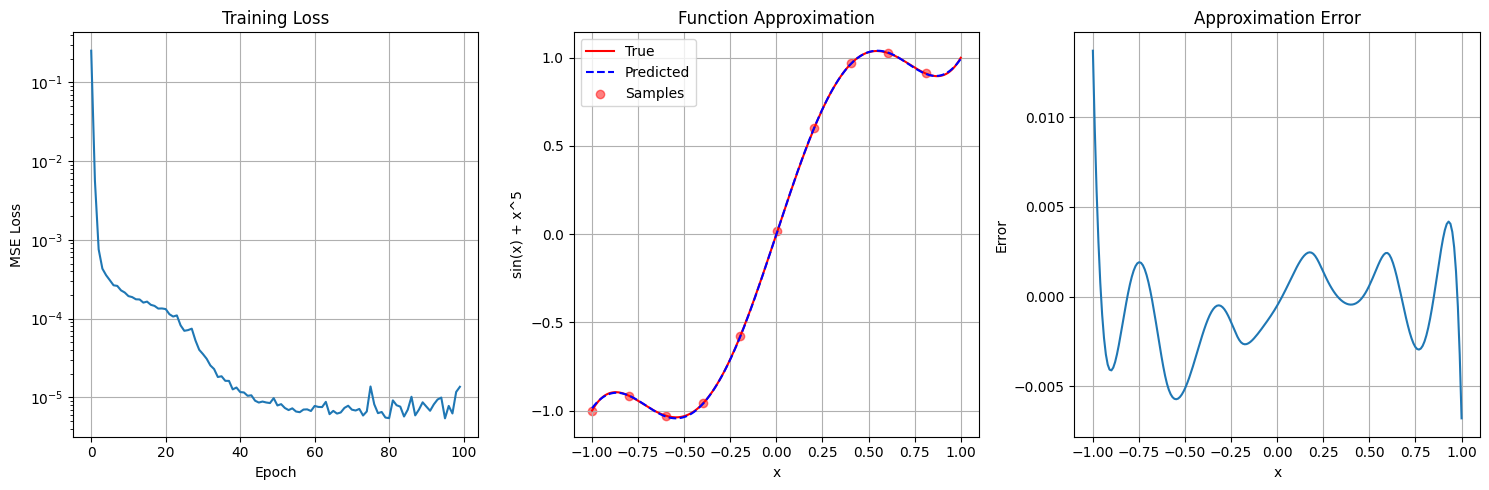

In [58]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def generate_data(n_samples=1000):
    """Generate training data for sin(x) + x²"""
    # Generate input in [-1, 1]
    x = 2 * torch.rand(n_samples, 1) - 1
    # Calculate target: sin(x) + x^5
    y = torch.sin(torch.pi*x) + x**5
    return x, y

def train_model(model, n_epochs=100, batch_size=32, lr=0.01):
    """Train the model"""
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.MSELoss()
    
    # Generate training data
    x_train, y_train = generate_data(1000)
    x_train = x_train.to(model.device)
    y_train = y_train.to(model.device)
    
    # Training history
    losses = []
    
    for epoch in range(n_epochs):
        # Shuffle data
        idx = torch.randperm(x_train.size(0))
        x_train = x_train[idx]
        y_train = y_train[idx]
        
        epoch_losses = []
        
        # Mini-batch training
        for i in range(0, len(x_train), batch_size):
            x_batch = x_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]
            
            # Forward pass
            y_pred, _, _, _ = model(x_batch)
            loss = criterion(y_pred, y_batch)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_losses.append(loss.item())
        
        avg_loss = np.mean(epoch_losses)
        losses.append(avg_loss)
        
        if epoch % 20 == 0:
            print(f'Epoch {epoch}, Loss: {avg_loss:.6f}')
    
    return losses

def plot_results(model, losses):
    """Plot training results and function approximation"""
    # Create figure
    plt.figure(figsize=(15, 5))
    
    # Plot 1: Training loss
    plt.subplot(131)
    plt.plot(losses)
    plt.yscale('log')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.grid(True)
    
    # Plot 2: Function approximation
    plt.subplot(132)
    
    # Generate test points
    x_test = torch.linspace(-1, 1, 200).view(-1, 1).to(model.device)
    y_test = torch.sin(torch.pi*x_test) + x_test**5
    
    # Get model predictions
    with torch.no_grad():
        y_pred, _, _, _ = model(x_test)
    
    # Plot true function and prediction
    plt.plot(x_test.cpu(), y_test.cpu(), 'r-', label='True')
    plt.plot(x_test.cpu(), y_pred.cpu(), 'b--', label='Predicted')
    plt.scatter(x_test[::20].cpu(), y_test[::20].cpu(), c='r', alpha=0.5, label='Samples')
    plt.title('Function Approximation')
    plt.xlabel('x')
    plt.ylabel('sin(x) + x^5')
    plt.legend()
    plt.grid(True)
    
    # Plot 3: Error
    plt.subplot(133)
    error = (y_pred - y_test).cpu().numpy()
    plt.plot(x_test.cpu(), error)
    plt.title('Approximation Error')
    plt.xlabel('x')
    plt.ylabel('Error')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Create and train model
if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Network architecture
    width = [1, 4, 1]  # Input dim=1, hidden dim=4, output dim=1
    
    # Define connection types to use both basis functions
    connection_types = [
        {  # First layer
            (0, 0): 'spline',   # Input to hidden1
            (0, 1): 'spline',   # Input to hidden2
            (0, 2): 'chebyshev',# Input to hidden3
            (0, 3): 'chebyshev' # Input to hidden4
        },
        {  # Second layer
            (0, 0): 'spline',    # Hidden1 to output
            (1, 0): 'chebyshev', # Hidden2 to output
            (2, 0): 'spline',    # Hidden3 to output
            (3, 0): 'chebyshev'  # Hidden4 to output
        }
    ]
    
    # Create model
    model = CustomMultKAN(
        width=width,
        connection_types=connection_types,
        device=device
    )
    
    # Train model
    print("Training model...")
    losses = train_model(model, n_epochs=100, lr=0.01)
    
    # Plot results
    plot_results(model, losses)
    
    # # Optional: Plot basis functions
    # def plot_layer_outputs(model):
    #     """Plot the outputs of each layer"""
    #     x_test = torch.linspace(-1, 1, 200).view(-1, 1).to(model.device)
    #     _, _, postacts, _ = model(x_test)
        
    #     # Plot each layer's outputs
    #     for layer_idx, acts in enumerate(postacts):
    #         plt.figure(figsize=(10, 5))
    #         acts = acts.cpu().detach().numpy()
            
    #         for j in range(acts.shape[1]):  # For each output
    #             for i in range(acts.shape[2]):  # For each input
    #                 plt.plot(x_test.cpu(), acts[:, j, i], 
    #                         label=f'out{j+1},in{i+1}')
            
    #         plt.title(f'Layer {layer_idx+1} Outputs')
    #         plt.xlabel('x')
    #         plt.ylabel('Output')
    #         plt.legend()
    #         plt.grid(True)
    #         plt.show()
    
    # # Plot layer outputs
    # plot_layer_outputs(model)

In [75]:
import torch
import torch.nn as nn
from kan import *

class CustomMultKAN(nn.Module):
    """
    Custom network that allows different basis functions between nodes
    with different domains for radial and angular variables
    """
    def __init__(self, width, connection_types=None, variable_types=None, 
                 radial_range=[0, 10], device='cpu'):
        super().__init__()
        
        self.width = width
        self.device = device
        self.radial_range = radial_range
        
        # Set default connection and variable types if none provided
        if connection_types is None:
            connection_types = [{(i, j): 'spline'
                               for i in range(width[l])
                               for j in range(width[l+1])}
                              for l in range(len(width)-1)]
            
        if variable_types is None:
            variable_types = ['radial'] * width[0]  # Default all to radial
            
        self.variable_types = variable_types
        
        # Create layers
        self.layers = nn.ModuleList()
        for l in range(len(width)-1):
            connections = connection_types[l]
            
            # Create spline and chebyshev layers
            spline_layer = KANLayer(
                in_dim=width[l],
                out_dim=width[l+1],
                device=device,
                grid_range=radial_range  # Use expanded range for splines
            )
            
            cheb_layer = ChebKANLayer(
                in_dim=width[l],
                out_dim=width[l+1],
                device=device
            )
            
            # Create masks for each type
            spline_mask = torch.zeros(width[l], width[l+1])
            cheb_mask = torch.zeros(width[l], width[l+1])
            
            for (i, j), basis in connections.items():
                if basis == 'spline':
                    spline_mask[i, j] = 1
                elif basis == 'chebyshev':
                    cheb_mask[i, j] = 1
            
            # Set masks
            spline_layer.mask = nn.Parameter(spline_mask.to(device), requires_grad=False)
            cheb_layer.mask = nn.Parameter(cheb_mask.to(device), requires_grad=False)
            
            # Combine into custom layer
            self.layers.append(CustomBasisLayer(
                spline_layer, 
                cheb_layer, 
                variable_types=variable_types,
                radial_range=radial_range
            ))

    def forward(self, x):
        preacts = []
        postacts = []
        postbasis = []
        
        for layer in self.layers:
            x, pre, post, basis = layer(x)
            preacts.append(pre)
            postacts.append(post)
            postbasis.append(basis)
            
        return x, preacts, postacts, postbasis

class CustomBasisLayer(nn.Module):
    def __init__(self, spline_layer, cheb_layer, variable_types, radial_range):
        super().__init__()
        self.spline_layer = spline_layer
        self.cheb_layer = cheb_layer
        self.variable_types = variable_types
        self.radial_range = radial_range

    def normalize_input(self, x):
        """Normalize inputs based on variable type"""
        x_normalized = x.clone()
        
        for i, var_type in enumerate(self.variable_types):
            if var_type == 'radial':
                # Use log-scale normalization for radial component
                x_min, x_max = self.radial_range
                x_normalized[:, i] = torch.log1p(x[:, i]) / torch.log1p(torch.tensor(x_max))
                x_normalized[:, i] = x_normalized[:, i] * 2 - 1  # Scale to [-1, 1]
            elif var_type == 'angular':
                # Ensure angular variable is properly scaled to [-1, 1]
                x_normalized[:, i] = x[:, i] * np.pi  # If input is in [-1, 1]
                
        return x_normalized

    def forward(self, x):
        # Normalize input
        x_normalized = self.normalize_input(x)
        
        # Process with spline layer (using original range for radial)
        y_spline, pre_s, post_s, basis_s = self.spline_layer(x)
        
        # Process with Chebyshev layer (using normalized input)
        y_cheb, pre_c, post_c, basis_c = self.cheb_layer(x_normalized)
        
        # Combine outputs with proper masking
        y = torch.zeros_like(y_spline)
        for i in range(self.spline_layer.mask.shape[0]):  # Input dimension
            for j in range(self.spline_layer.mask.shape[1]):  # Output dimension
                if self.spline_layer.mask[i,j]:
                    y[:, j] += y_spline[:, j]
                if self.cheb_layer.mask[i,j]:
                    y[:, j] += y_cheb[:, j]
        
        # Handle intermediate outputs
        preacts = pre_s
        
        # Ensure proper broadcasting for masks
        spline_mask = self.spline_layer.mask.permute(1, 0)[None, :, :]
        cheb_mask = self.cheb_layer.mask.permute(1, 0)[None, :, :]
        
        # Combine intermediate outputs
        postacts = post_s * spline_mask + post_c * cheb_mask
        postbasis = basis_s * spline_mask + basis_c * cheb_mask
        
        return y, preacts, postacts, postbasis

Training model...
Epoch 0, Loss: 0.660376
Epoch 20, Loss: 0.000270
Epoch 40, Loss: 0.001373
Epoch 60, Loss: 0.000432
Epoch 80, Loss: 0.000311
Epoch 100, Loss: 0.000216
Epoch 120, Loss: 0.000093
Epoch 140, Loss: 0.001521
Epoch 160, Loss: 0.000066
Epoch 180, Loss: 0.000150


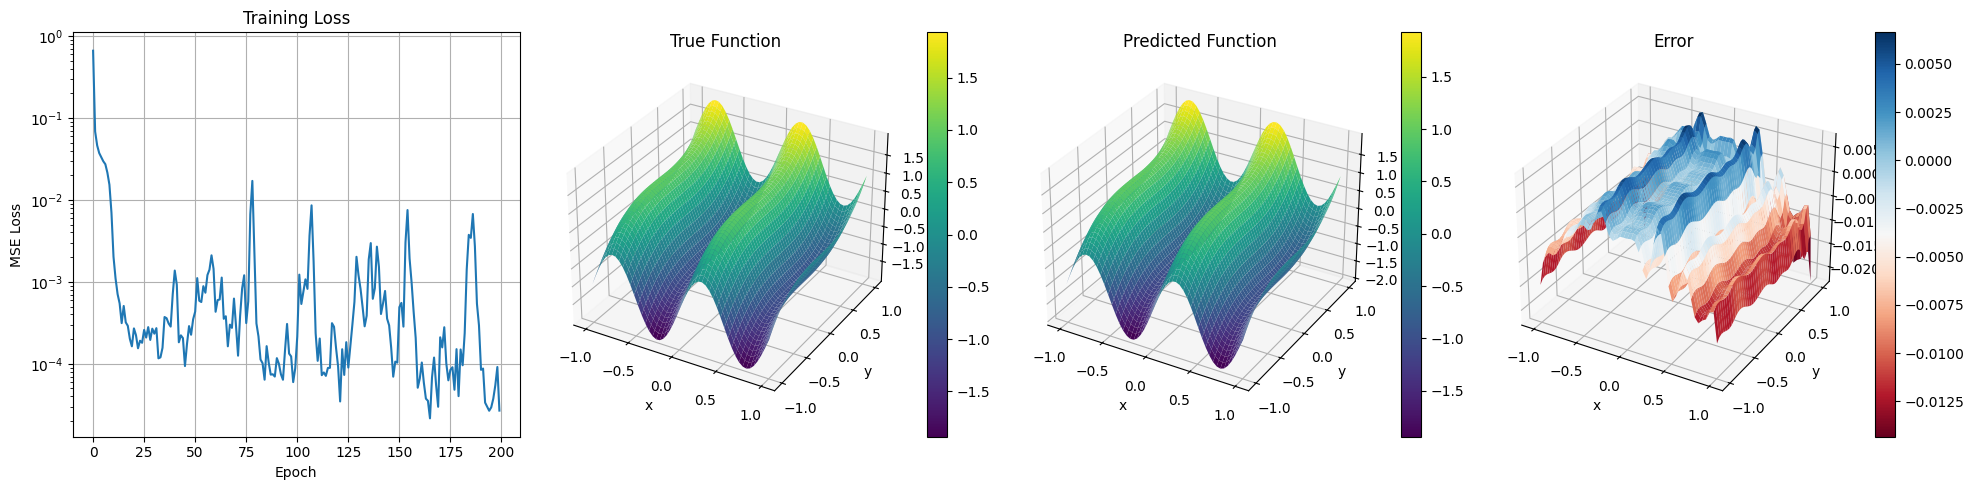

TypeError: sin(): argument 'input' (position 1) must be Tensor, not float

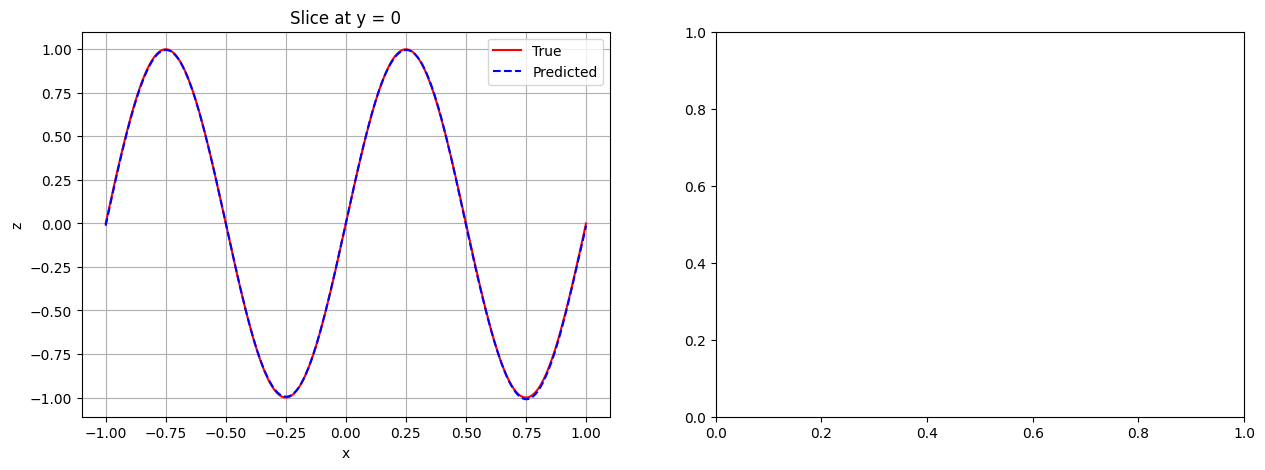

In [69]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

def generate_data(n_samples=1000):
    """Generate training data for sin(x) + y"""
    # Generate inputs in [-1, 1] x [-1, 1]
    x = 2 * torch.rand(n_samples, 2) - 1  # First column is x, second is y
    # Calculate target: sin(x) + y
    target = torch.sin(2*torch.pi*x[:,0]) + x[:,1]**3
    return x, target.unsqueeze(1)

def train_model(model, n_epochs=100, batch_size=32, lr=0.01):
    """Train the model"""
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.MSELoss()
    
    # Generate training data
    x_train, y_train = generate_data(1000)
    x_train = x_train.to(model.device)
    y_train = y_train.to(model.device)
    
    # Training history
    losses = []
    
    for epoch in range(n_epochs):
        # Shuffle data
        idx = torch.randperm(x_train.size(0))
        x_train = x_train[idx]
        y_train = y_train[idx]
        
        epoch_losses = []
        
        # Mini-batch training
        for i in range(0, len(x_train), batch_size):
            x_batch = x_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]
            
            # Forward pass
            y_pred, _, _, _ = model(x_batch)
            loss = criterion(y_pred, y_batch)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_losses.append(loss.item())
        
        avg_loss = np.mean(epoch_losses)
        losses.append(avg_loss)
        
        if epoch % 20 == 0:
            print(f'Epoch {epoch}, Loss: {avg_loss:.6f}')
    
    return losses

def plot_results(model, losses):
    """Plot training results and function approximation"""
    # Create figure
    fig = plt.figure(figsize=(20, 5))
    
    # Plot 1: Training loss
    ax1 = fig.add_subplot(141)
    ax1.plot(losses)
    ax1.set_yscale('log')
    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('MSE Loss')
    ax1.grid(True)
    
    # Create meshgrid for surface plots
    x = np.linspace(-1, 1, 50)
    y = np.linspace(-1, 1, 50)
    X, Y = np.meshgrid(x, y)
    
    # True function
    Z_true = np.sin(2*np.pi*X) + Y**3
    
    # Model predictions
    xy_grid = torch.tensor(np.stack([X.flatten(), Y.flatten()], axis=1), 
                          dtype=torch.float32).to(model.device)
    with torch.no_grad():
        Z_pred = model(xy_grid)[0].cpu().numpy().reshape(X.shape)
    
    # Plot 2: True function surface
    ax2 = fig.add_subplot(142, projection='3d')
    surf2 = ax2.plot_surface(X, Y, Z_true, cmap='viridis')
    ax2.set_title('True Function')
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    fig.colorbar(surf2, ax=ax2)
    
    # Plot 3: Predicted function surface
    ax3 = fig.add_subplot(143, projection='3d')
    surf3 = ax3.plot_surface(X, Y, Z_pred, cmap='viridis')
    ax3.set_title('Predicted Function')
    ax3.set_xlabel('x')
    ax3.set_ylabel('y')
    fig.colorbar(surf3, ax=ax3)
    
    # Plot 4: Error
    ax4 = fig.add_subplot(144, projection='3d')
    error = Z_pred - Z_true
    surf4 = ax4.plot_surface(X, Y, error, cmap='RdBu')
    ax4.set_title('Error')
    ax4.set_xlabel('x')
    ax4.set_ylabel('y')
    fig.colorbar(surf4, ax=ax4)
    
    plt.tight_layout()
    plt.show()
    
    # Plot slices
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Slice at y = 0
    y_slice = 0
    x_test = torch.linspace(-1, 1, 200).view(-1, 1)
    xy_test = torch.cat([x_test, torch.zeros_like(x_test)], dim=1).to(model.device)
    with torch.no_grad():
        z_pred = model(xy_test)[0].cpu()
    
    z_true = torch.sin(2*torch.pi*x_test) + 0
    
    ax1.plot(x_test, z_true, 'r-', label='True')
    ax1.plot(x_test, z_pred, 'b--', label='Predicted')
    ax1.set_title(f'Slice at y = {y_slice}')
    ax1.set_xlabel('x')
    ax1.set_ylabel('z')
    ax1.legend()
    ax1.grid(True)
    
    # Slice at x = 0
    x_slice = 0
    y_test = torch.linspace(-1, 1, 200).view(-1, 1)
    xy_test = torch.cat([torch.zeros_like(y_test), y_test], dim=1).to(model.device)
    with torch.no_grad():
        z_pred = model(xy_test)[0].cpu()
    
    z_true = torch.sin(2*torch.pi*0) + y_test**3
    
    ax2.plot(y_test, z_true, 'r-', label='True')
    ax2.plot(y_test, z_pred, 'b--', label='Predicted')
    ax2.set_title(f'Slice at x = {x_slice}')
    ax2.set_xlabel('y')
    ax2.set_ylabel('z')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

# Create and train model
if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Network architecture
    width = [2, 8, 1]  # Input dim=2, hidden dim=8, output dim=1
    
    # Define connection types
    connection_types = [
        {  # First layer
            (0, 0): 'spline',    # x to hidden1
            (0, 1): 'spline',    # x to hidden2
            (0, 2): 'chebyshev', # x to hidden3
            (0, 3): 'chebyshev', # x to hidden4
            (1, 4): 'spline',    # y to hidden5
            (1, 5): 'spline',    # y to hidden6
            (1, 6): 'chebyshev', # y to hidden7
            (1, 7): 'chebyshev'  # y to hidden8
        },
        {  # Second layer
            (0, 0): 'spline',    # Hidden1 to output
            (1, 0): 'spline',    # Hidden2 to output
            (2, 0): 'chebyshev', # Hidden3 to output
            (3, 0): 'chebyshev', # Hidden4 to output
            (4, 0): 'spline',    # Hidden5 to output
            (5, 0): 'spline',    # Hidden6 to output
            (6, 0): 'chebyshev', # Hidden7 to output
            (7, 0): 'chebyshev'  # Hidden8 to output
        }
    ]
    
    # Create model
    model = CustomMultKAN(
        width=width,
        connection_types=connection_types,
        device=device
    )
    
    # Train model
    print("Training model...")
    losses = train_model(model, n_epochs=200, lr=0.01)
    
    # Plot results
    plot_results(model, losses)

Training model...
Epoch 0, Loss: 2.569400
Epoch 20, Loss: 0.341789
Epoch 40, Loss: 0.233814
Epoch 60, Loss: 0.149499
Epoch 80, Loss: 0.051802
Epoch 100, Loss: 0.020368
Epoch 120, Loss: 0.013365
Epoch 140, Loss: 0.010063
Epoch 160, Loss: 0.007256
Epoch 180, Loss: 0.006617
Epoch 200, Loss: 0.005522
Epoch 220, Loss: 0.005200
Epoch 240, Loss: 0.004318
Epoch 260, Loss: 0.004106
Epoch 280, Loss: 0.003753

Final RMSE: nan


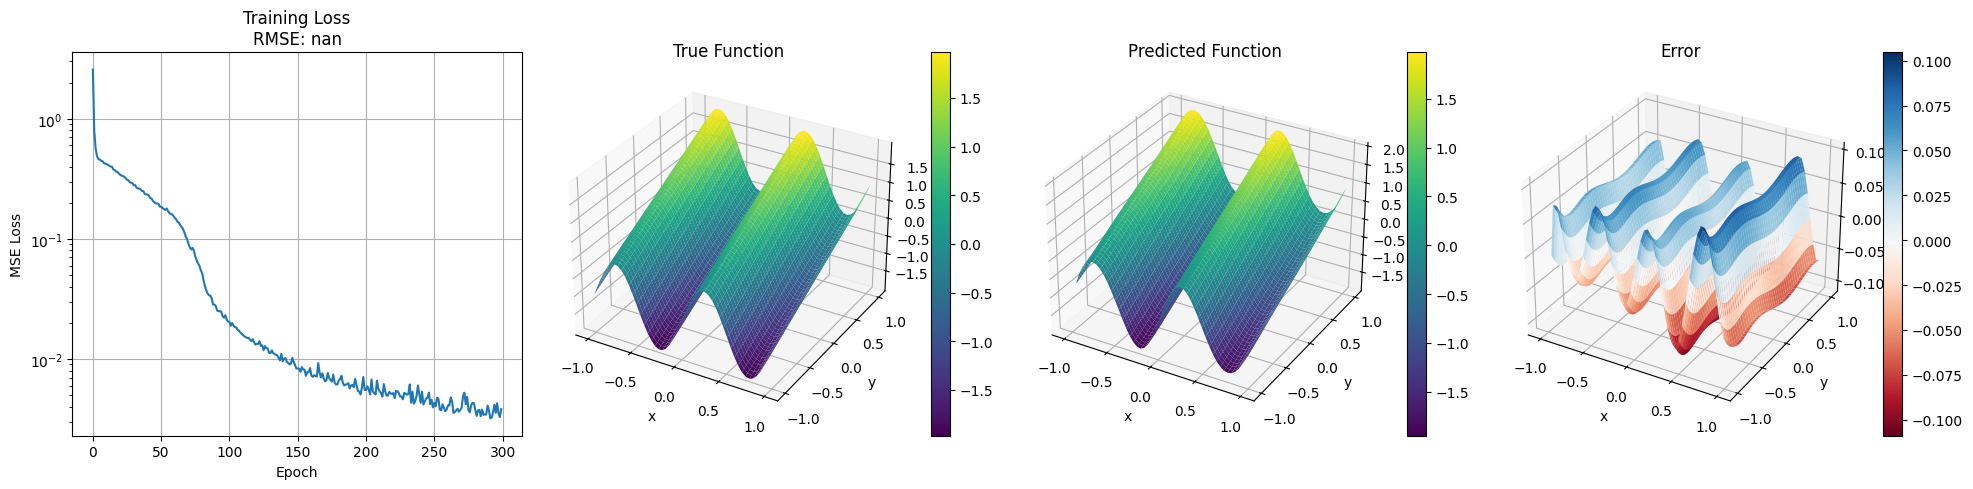

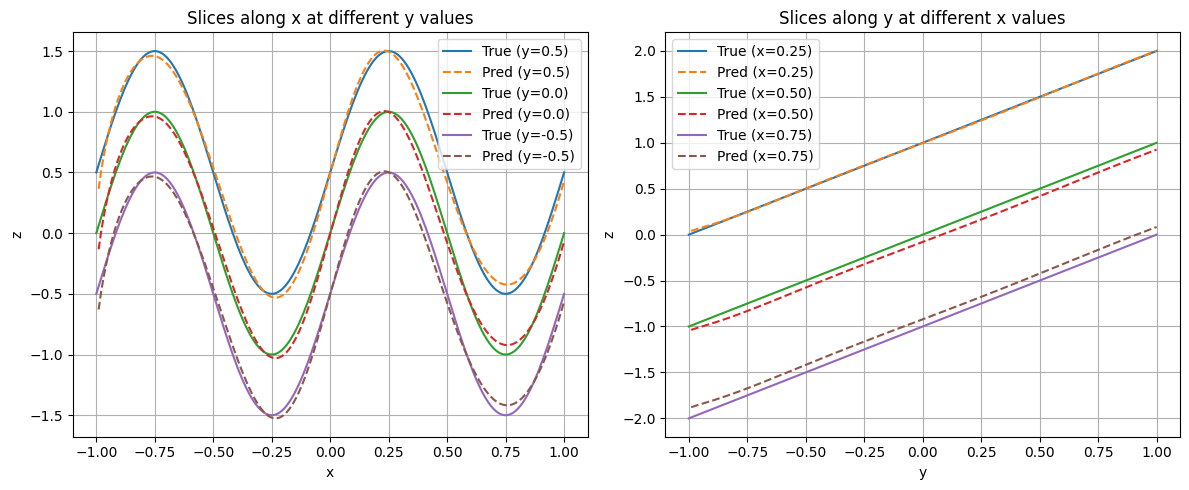

In [ ]:
def generate_data(n_samples=5000):
    """Generate training data for sin(x)*y"""
    # Generate inputs in [-1, 1]
    x = 2 * torch.rand(n_samples, 2) - 1  # Two columns: x, y only
    # Calculate target: sin(x)*y
    target = torch.sin(2*torch.pi*x[:,0]) + x[:,1]
    return x, target.unsqueeze(1)



def plot_results(model, losses):
    # Calculate RMSE
    
    # Create figure
    fig = plt.figure(figsize=(20, 5))
    
    # Plot training loss
    ax1 = fig.add_subplot(141)
    ax1.plot(losses)
    ax1.set_yscale('log')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('MSE Loss')
    ax1.grid(True)
    
    # Create 2D surface plot
    n_points = 50
    x = np.linspace(-1, 1, n_points)
    y = np.linspace(-1, 1, n_points)
    X, Y = np.meshgrid(x, y)
    
    # Create grid points
    points = np.stack([X.flatten(), Y.flatten()], axis=1)
    points_tensor = torch.tensor(points, dtype=torch.float32).to(model.device)
    
    # True function
    Z_true = np.sin(2*np.pi*X) + Y
    
    # Model predictions
    with torch.no_grad():
        Z_pred = model(points_tensor)[0].cpu().numpy().reshape(X.shape)
    
    # Plot true function
    ax2 = fig.add_subplot(142, projection='3d')
    surf = ax2.plot_surface(X, Y, Z_true, cmap='viridis')
    ax2.set_title('True Function')
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    fig.colorbar(surf, ax=ax2)
    
    # Plot predicted function
    ax3 = fig.add_subplot(143, projection='3d')
    surf = ax3.plot_surface(X, Y, Z_pred, cmap='viridis')
    ax3.set_title('Predicted Function')
    ax3.set_xlabel('x')
    ax3.set_ylabel('y')
    fig.colorbar(surf, ax=ax3)
    
    # Plot error
    ax4 = fig.add_subplot(144, projection='3d')
    error = Z_pred - Z_true
    surf = ax4.plot_surface(X, Y, error, cmap='RdBu')
    ax4.set_title('Error')
    ax4.set_xlabel('x')
    ax4.set_ylabel('y')
    fig.colorbar(surf, ax=ax4)
    
    plt.tight_layout()
    plt.show()
    
    # Plot 1D slices
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Slice along x (at different y values)
    x_test = torch.linspace(-1, 1, 200).view(-1, 1)
    y_values = [0.5, 0.0, -0.5]
    
    for y_val in y_values:
        y_val = torch.tensor(y_val)
        xy_test = torch.cat([x_test, torch.ones_like(x_test) * y_val], dim=1).to(model.device)
        
        with torch.no_grad():
            z_pred = model(xy_test)[0].cpu()
        
        z_true = torch.sin(2*torch.pi*x_test) + y_val
        
        ax1.plot(x_test.numpy(), z_true.numpy(), '-', label=f'True (y={y_val.item()})')
        ax1.plot(x_test.numpy(), z_pred.numpy(), '--', label=f'Pred (y={y_val.item()})')
    
    ax1.set_title('Slices along x at different y values')
    ax1.set_xlabel('x')
    ax1.set_ylabel('z')
    ax1.legend()
    ax1.grid(True)
    
    # Slice along y (at different x values)
    y_test = torch.linspace(-1, 1, 200).view(-1, 1)
    x_values = [0.25, 0.5, 0.75]
    
    for x_val in x_values:
        x_val = torch.tensor(x_val)
        xy_test = torch.cat([torch.ones_like(y_test) * x_val, y_test], dim=1).to(model.device)
        
        with torch.no_grad():
            z_pred = model(xy_test)[0].cpu()
        
        z_true = torch.sin(2*torch.pi*x_val) + y_test
        
        ax2.plot(y_test.numpy(), z_true.numpy(), '-', label=f'True (x={x_val.item():.2f})')
        ax2.plot(y_test.numpy(), z_pred.numpy(), '--', label=f'Pred (x={x_val.item():.2f})')
    
    ax2.set_title('Slices along y at different x values')
    ax2.set_xlabel('y')
    ax2.set_ylabel('z')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    

if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Network architecture
    width = [2, 10, 1]  # Input dim=2 (x,y), hidden dim=10, output dim=1
    
    # Define connection types
    connection_types = [
        {  # First layer
            # x connections
            (0, 0): 'spline',    
            (0, 1): 'spline',    
            (0, 2): 'chebyshev', 
            (0, 3): 'chebyshev', 
            (0, 4): 'spline',    
            
            # y connections
            (1, 5): 'spline',    
            (1, 6): 'spline',    
            (1, 7): 'chebyshev', 
            (1, 8): 'chebyshev', 
            (1, 9): 'spline',    
        },
        {  # Second layer
            (i, 0): 'spline' if i % 2 == 0 else 'chebyshev'
            for i in range(10)
        }
    ]

     # Create model
    model = CustomMultKAN(
        width=width,
        connection_types=connection_types,
        device=device
    )
    
    # Train model
    print("Training model...")
    losses = train_model(model, n_epochs=300, lr=0.001)
    
    # Plot results
    plot_results(model, losses)

In [113]:
model.plot()

AttributeError: 'CustomMultKAN' object has no attribute 'plot'